In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms # transformation functions for cvision
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np

Data should come from this two dstes.MINST, but it does not work.

url = 'https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz' also has the data split into 2 different folders, training and testing. Each folder contains folders numbered and inside there are the images. We now have to set the arrays.

We have to set a tuple foreach image where initial is the image to tensor and the second is the class of the image

In [2]:
# train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
def PlotParameters(model):
    plt.figure(figsize=(12,5))
    plt.subplots_adjust(hspace=0.01, wspace=0.1)
    for i in range(0,10):
        plt.subplot(2,5,i+1)
        plt.imshow(np.resize(list(model.parameters())[0].detach().numpy()[i], (28,28)), cmap='seismic')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("class: {0}".format(i))

def show_data(data_sample):
    plt.figure(figsize=(3,3))
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [4]:
# Load the dataset as we want with the transform. Grayscale (since it loads RGB)
# and ToTensor (2D tensor)

transform = transforms.Compose([
    transforms.Grayscale(), # Tried to load without grayscale but it loads as RGB
    transforms.ToTensor()
    # transforms.Lambda(lambda x: x.squeeze(0)) # Remove the first dimension. The image was loaded as [1, 28, 28]
    
    ])

train_dataset = dsets.ImageFolder('./data/MNIST/training/', transform=transform)
validation_dataset = dsets.ImageFolder('./data/MNIST/testing/', transform=transform)

# Shuffle the dataset since it loads ordered.

def shuffle_dataset(dataset):
    # Shuffle the dataset
    dataset_size = len(dataset)
    indices = torch.randperm(dataset_size).tolist()  # Generate a list of random indices
    shuffled_dataset = torch.utils.data.Subset(dataset, indices)  # Create a shuffled subset
    return shuffled_dataset

train_dataset = shuffle_dataset(train_dataset)
validation_dataset = shuffle_dataset(validation_dataset)

In [5]:
# Define softmax classifier class

class SoftMax(nn.Module):

    # Constructor
    def __init__(self, in_size, out_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
    
    # Predictor
    def forward(self, x):
        z = self.linear(x)
        return z        

In [6]:
# Set input size and output size

input_dim = 28*28
output_dim = 10

# Create the model

model = SoftMax(input_dim, output_dim)
print(model)

SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


W: torch.Size([10, 784])
b: torch.Size([10])


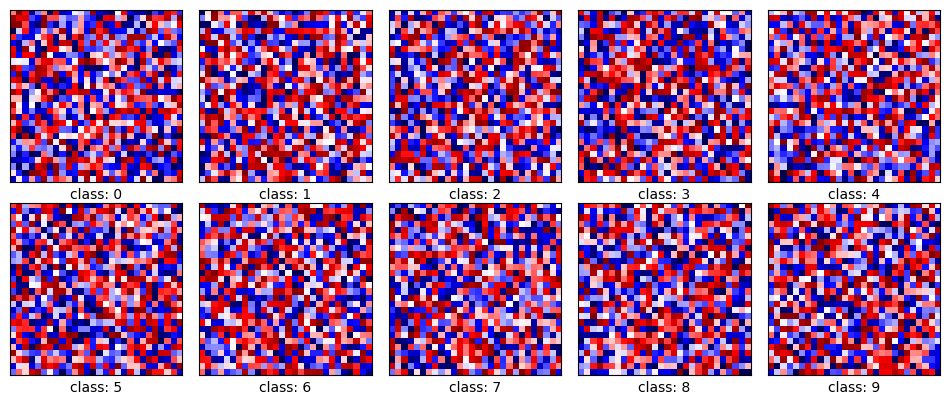

In [7]:
# Print the parameters

print('W:' , list(model.parameters())[0].size())
print('b:' , list(model.parameters())[1].size())

# Plot the model parameters for each class

PlotParameters(model) # each weight parameter is 28x28. Initially they look like noise.

In [8]:
# Define the learning rate, optimizer, criterion and data loader

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [9]:
# Train the model

n_epochs = 100
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        print("epoch number {0}".format(epoch+1), end='\r')
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

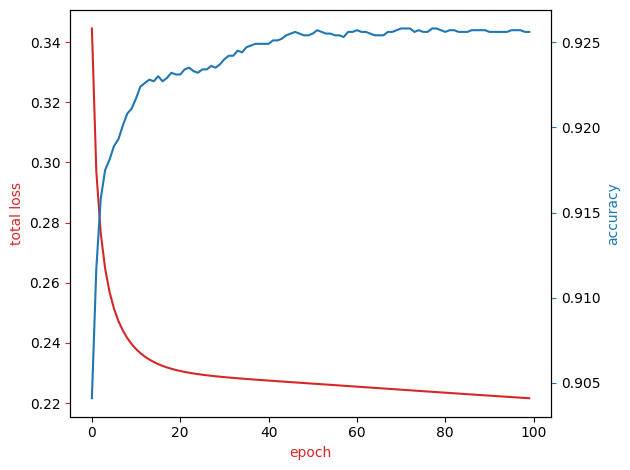

In [10]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

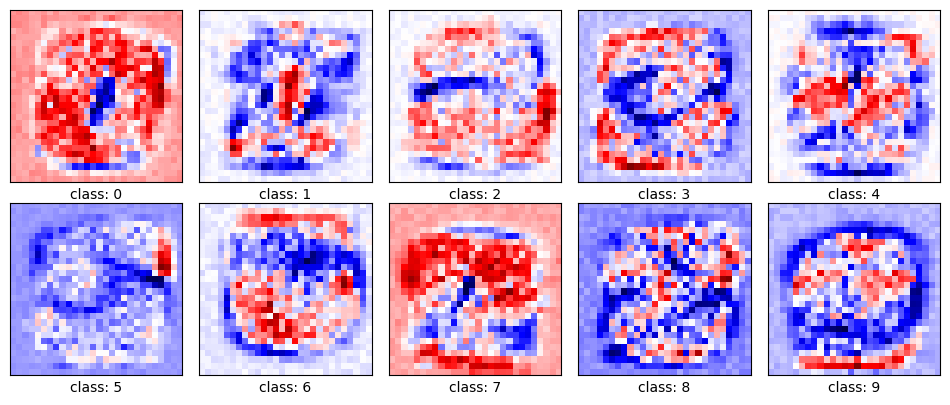

In [14]:
# Plot the parameters

PlotParameters(model) # each weight parameter is 28x28. Finally look like numbers.

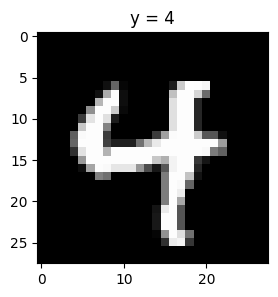

yhat: tensor([9])
probability of class  0.7543083429336548


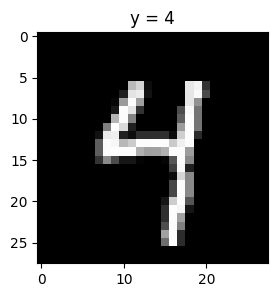

yhat: tensor([9])
probability of class  0.5028300881385803


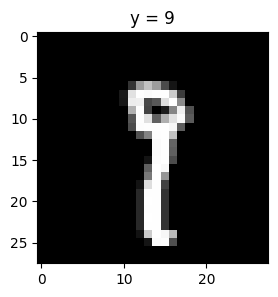

yhat: tensor([7])
probability of class  0.7735195159912109


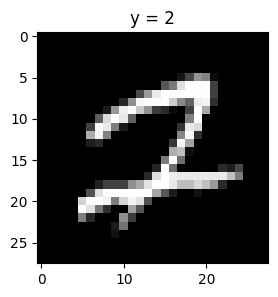

yhat: tensor([5])
probability of class  0.7899838089942932


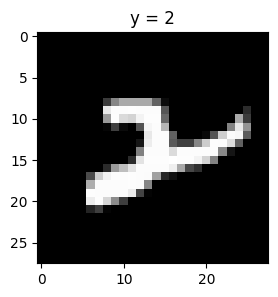

yhat: tensor([8])
probability of class  0.9863302111625671


In [15]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

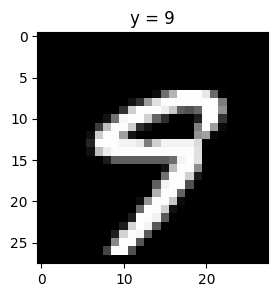

yhat: tensor([9])
probability of class  tensor(0.9639, grad_fn=<MaxBackward1>)


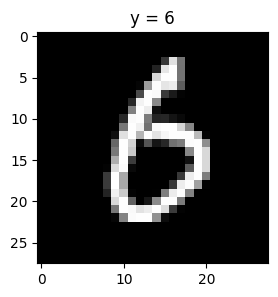

yhat: tensor([6])
probability of class  tensor(0.5434, grad_fn=<MaxBackward1>)


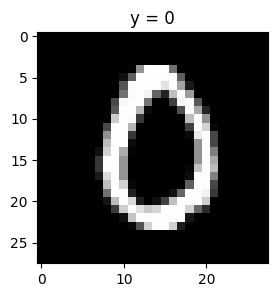

yhat: tensor([0])
probability of class  tensor(0.9953, grad_fn=<MaxBackward1>)


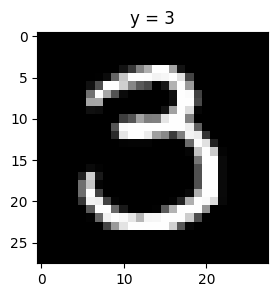

yhat: tensor([3])
probability of class  tensor(0.9754, grad_fn=<MaxBackward1>)


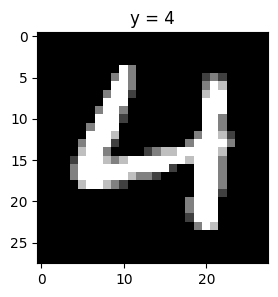

yhat: tensor([4])
probability of class  tensor(0.9937, grad_fn=<MaxBackward1>)


In [13]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)))
        count += 1
    if count >= 5:
        break  